In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score, roc_curve
import time

In [3]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from catboost import CatBoostClassifier,Pool,cv

In [5]:
df=pd.read_csv(r"C:\Users\reyha\Desktop\data science class\telco customer churn\WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [6]:
df= df.replace(r'^\s*$', np.nan, regex=True)

In [7]:
if "tenure" in df.columns:  
    df.loc[df["tenure"] == 0, "TotalCharges"] = 0

In [8]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])
print(df["TotalCharges"].dtype)

float64


In [9]:
#model
X=df.drop(columns=["customerID","Churn"])
y = df["Churn"].map({"No": 0, "Yes": 1})

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

In [11]:
# همه ستون‌های دسته‌ای
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# ایندکس هر ستون دسته‌ای
cat_indices = [X.columns.get_loc(c) for c in cat_cols]

print("Categorical columns:", cat_cols)
print("Their indices:", cat_indices)


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Their indices: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [12]:
cat_param = {
    "depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "iterations": [200, 400, 700],
    "l2_leaf_reg": [1, 3, 5],
}


cat = CatBoostClassifier(
     loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    allow_writing_files=False,
    verbose=0
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cat_model = RandomizedSearchCV(
    cat, cat_param, n_iter=15,
    scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, random_state=42, verbose=2
)

t0 = time.time()
cat_model.fit(X, y, cat_features=cat_indices,
               early_stopping_rounds=100, verbose=100)
cat_time = time.time() - t0

print(f"Training time: {cat_time:.2f} seconds")
print("Best CV AUC:", cat_model.best_score_)
print("Best params:", cat_model.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
0:	total: 296ms	remaining: 3m 27s
100:	total: 6.04s	remaining: 35.8s
200:	total: 11.6s	remaining: 28.8s
300:	total: 17s	remaining: 22.5s
400:	total: 20.9s	remaining: 15.6s
500:	total: 24.2s	remaining: 9.62s
600:	total: 27.4s	remaining: 4.51s
699:	total: 30.6s	remaining: 0us
Training time: 489.73 seconds
Best CV AUC: 0.8481658195752203
Best params: {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 3}


In [13]:
results = pd.DataFrame(cat_model.cv_results_)
print(results[["params","mean_test_score","std_test_score","rank_test_score"]].head())

                                              params  mean_test_score  \
0  {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iter...         0.846161   
1  {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iter...         0.848143   
2  {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'ite...         0.848166   
3  {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'ite...         0.843849   
4  {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iter...         0.843933   

   std_test_score  rank_test_score  
0        0.010934                7  
1        0.010491                2  
2        0.009300                1  
3        0.009140               12  
4        0.009186               11  


In [14]:
best_model = cat_model.best_estimator_
best_model.fit(X_train, y_train, cat_features=cat_indices, verbose=100)

0:	total: 29.5ms	remaining: 20.6s
100:	total: 3.74s	remaining: 22.2s
200:	total: 7.08s	remaining: 17.6s
300:	total: 10.1s	remaining: 13.4s
400:	total: 13.7s	remaining: 10.2s
500:	total: 16.9s	remaining: 6.73s
600:	total: 22.5s	remaining: 3.71s
699:	total: 27.7s	remaining: 0us


In [ ]:

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Confusion Matrix:\n{confusion}")
print(f"Classification Report:\n{report}")

Accuracy: 0.80
Confusion Matrix:
[[938  97]
 [179 195]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



Test ROC-AUC: 0.8452607920638612


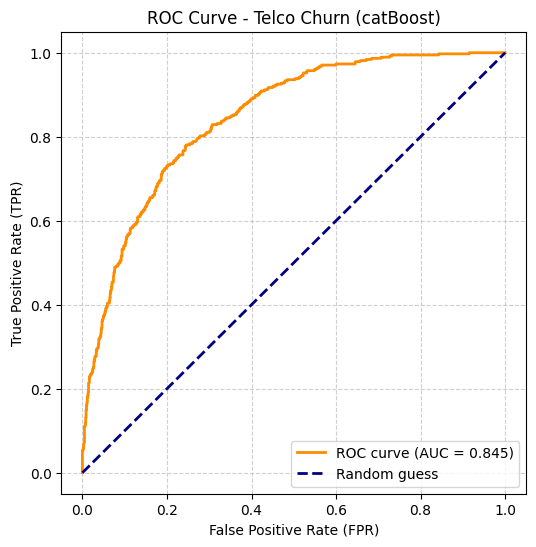

In [ ]:
y_proba = best_model.predict_proba(X_test)[:, 1]  
auc = roc_auc_score(y_test, y_proba)
print("Test ROC-AUC:", auc)

fpr, tpr, thr = roc_curve(y_test, y_proba)


plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--", label="Random guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Telco Churn (catBoost)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

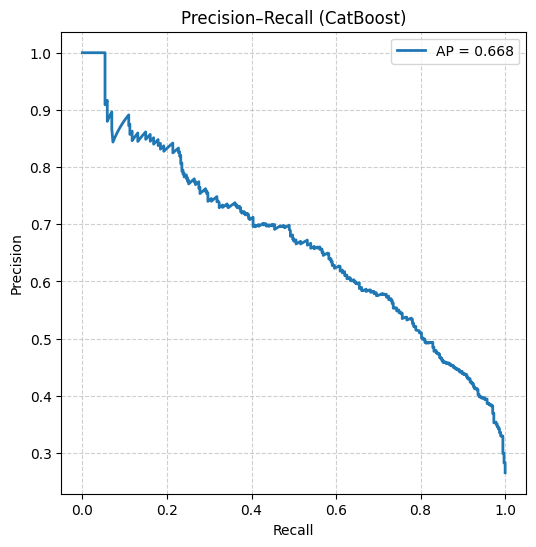

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
y_proba = best_model.predict_proba(X_test)[:,1]
ap = average_precision_score(y_test, y_proba)
p, r, th = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(r, p, lw=2, label=f'AP = {ap:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall (CatBoost)')
plt.legend(); plt.grid(True, ls='--', alpha=0.6); plt.show()


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.metrics import roc_curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
j_scores = tpr - fpr
t_opt = thr[j_scores.argmax()]  

y_pred = (y_proba >= t_opt).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Optimal threshold:", float(t_opt))
print(cm)
print(classification_report(y_test, y_pred, digits=3))

Optimal threshold: 0.2962104761341079
[[783 252]
 [ 83 291]]
              precision    recall  f1-score   support

           0      0.904     0.757     0.824      1035
           1      0.536     0.778     0.635       374

    accuracy                          0.762      1409
   macro avg      0.720     0.767     0.729      1409
weighted avg      0.806     0.762     0.774      1409



             Feature  CatBoost Importance  Permutation Importance
14          Contract            29.216800                0.055749
4             tenure            18.847815                0.042257
7    InternetService            11.566916                0.011044
11       TechSupport             8.858869                0.003668
17    MonthlyCharges             8.727601                0.003022
8     OnlineSecurity             6.598687                0.005350
18      TotalCharges             4.194233                0.005743
16     PaymentMethod             4.046545                0.003314
15  PaperlessBilling             2.164018                0.001644
9       OnlineBackup             1.935825                0.000262
6      MultipleLines             1.412176                0.001833
12       StreamingTV             0.651115               -0.000140
13   StreamingMovies             0.569315                0.000210
3         Dependents             0.383422                0.000130
1      Sen

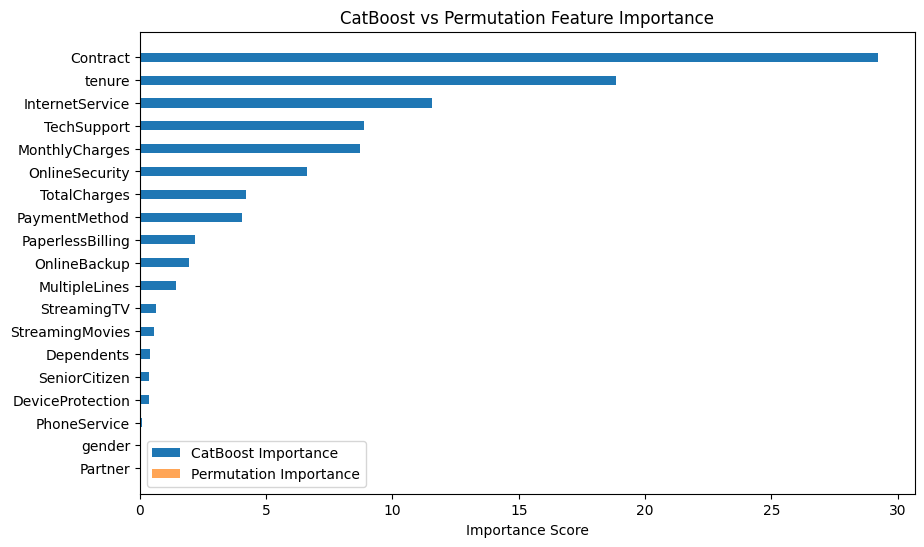

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


cat_importance = best_model.get_feature_importance(type='PredictionValuesChange')
cat_df = pd.DataFrame({
    'Feature': X_test.columns,
    'CatBoost Importance': cat_importance
})


perm_result = permutation_importance(best_model, X_test, y_test,
                                     n_repeats=10,
                                     random_state=42,
                                     scoring='roc_auc')
perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Permutation Importance': perm_result.importances_mean
})


imp_df = pd.merge(cat_df, perm_df, on='Feature')
imp_df = imp_df.sort_values(by='CatBoost Importance', ascending=False)

print(imp_df)


fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.4
features = imp_df['Feature']


ax.barh(features, imp_df['CatBoost Importance'], 
        height=bar_width, label='CatBoost Importance')
ax.barh(features, imp_df['Permutation Importance'], 
        height=bar_width, label='Permutation Importance', alpha=0.7)

ax.set_xlabel("Importance Score")
ax.set_title("CatBoost vs Permutation Feature Importance")
ax.legend()
plt.gca().invert_yaxis()
plt.show()


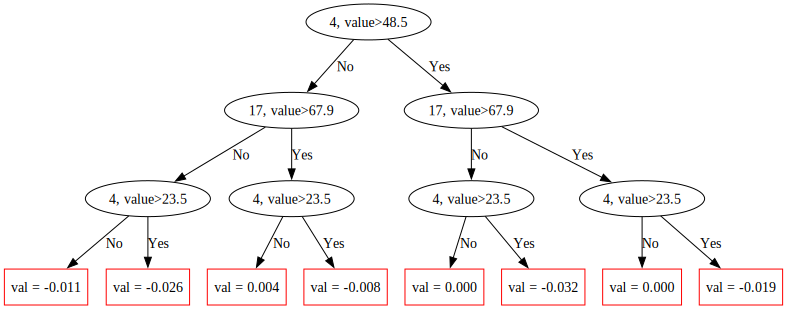

In [18]:
from catboost import CatBoostClassifier
tree_idx = 0
best_model.plot_tree(tree_idx)

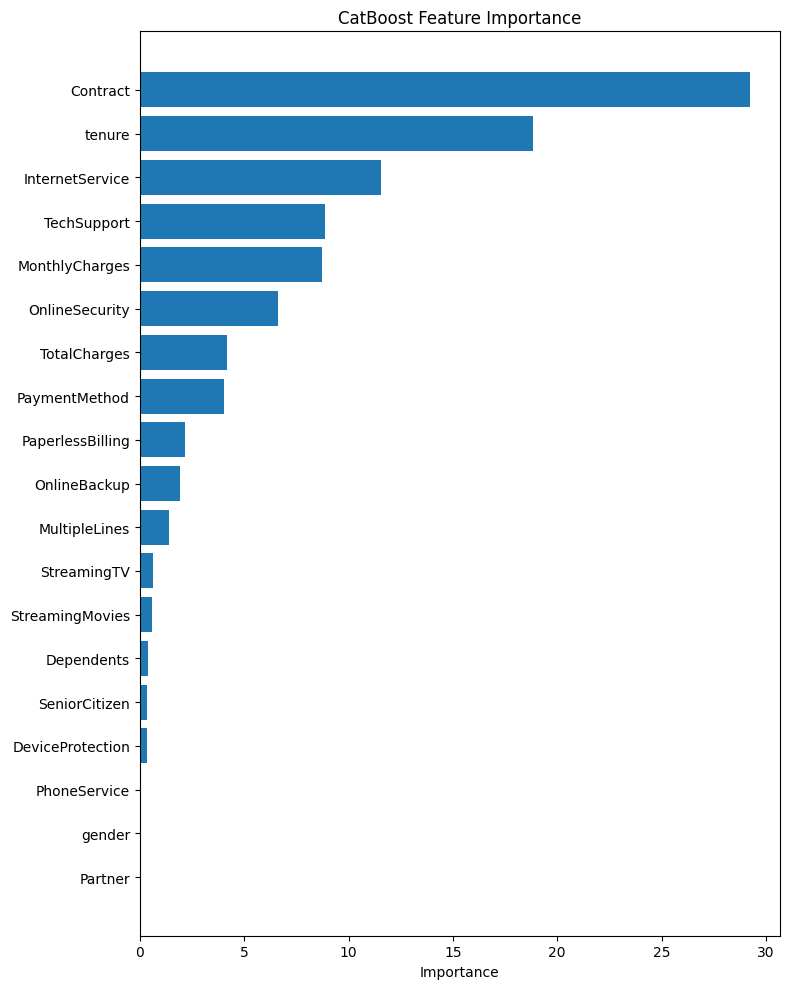

In [ ]:
feature_names = list(X_train.columns)
fi = best_model.get_feature_importance()  

order = np.argsort(fi)
plt.figure(figsize=(8, 10))
plt.barh(np.array(feature_names)[order], np.array(fi)[order])
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

C:\Users\reyha\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


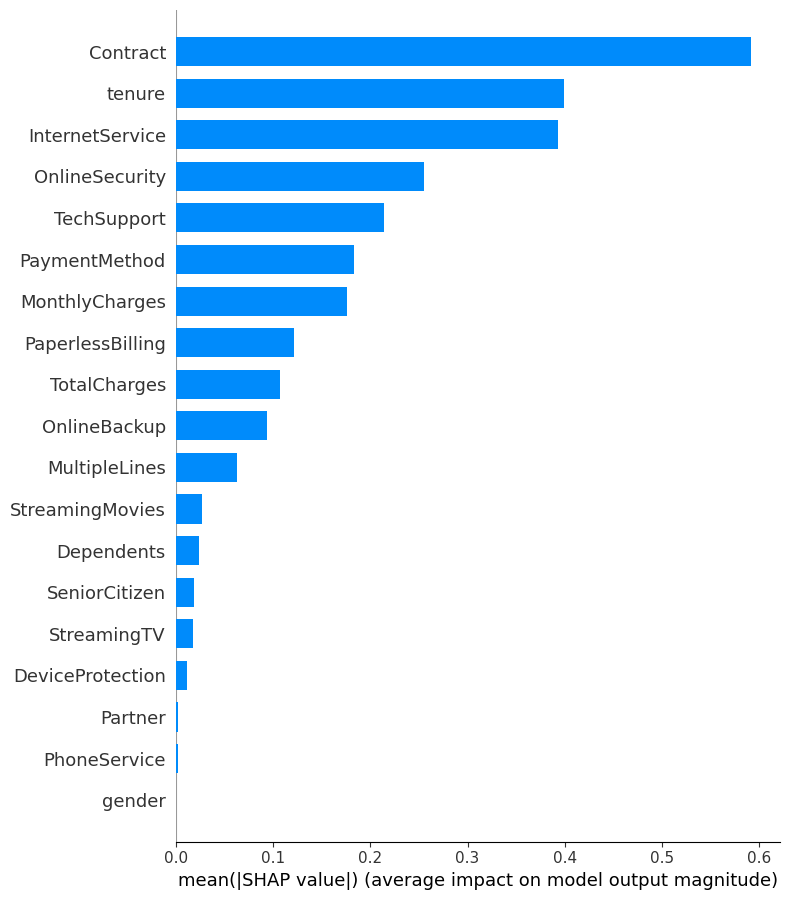

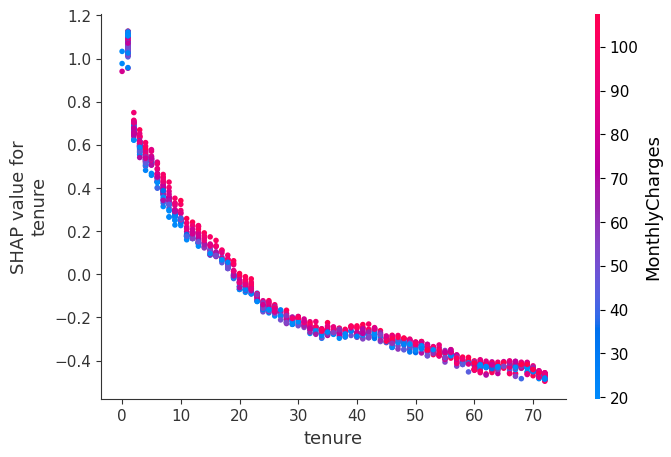

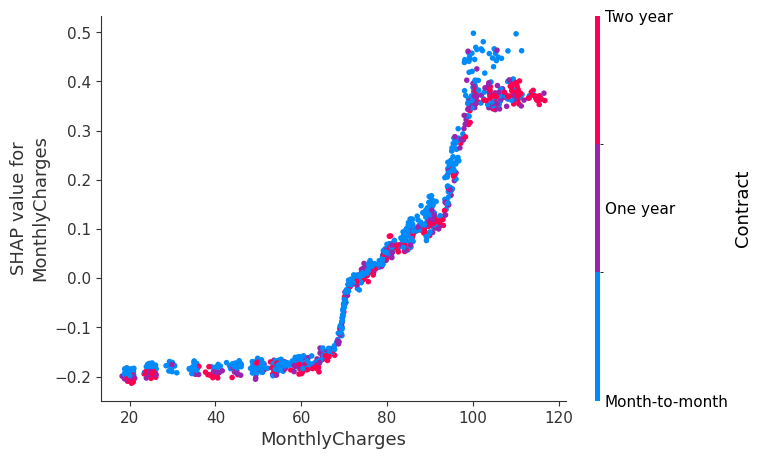

In [ ]:
import shap



shap.initjs()


explainer   = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test, plot_type="bar")


i = 0
shap.force_plot(explainer.expected_value, shap_values[i, :], X_test.iloc[i, :])


shap.dependence_plot("tenure", shap_values, X_test)
shap.dependence_plot("MonthlyCharges", shap_values, X_test)